In [387]:
%%capture
!pip install datasets
!pip install contractions

In [388]:
# Standard library imports
import logging
import re
import string

# Related third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
import contractions

# Local application/library specific imports
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
import random
from datasets import load_dataset, concatenate_datasets



```
# This is formatted as code
```

# Importing Data

Firstly, we download key components from the NLTK library, which are requireded for preprocessing tasks further in the code.

In [389]:
nltk.download('wordnet') #lexical database of English words
nltk.download('punkt') #tokenizer for splitting text into a list of sentences
nltk.download('stopwords') #list of common words that do not contribute to the main meaning of text
nltk.download('averaged_perceptron_tagger') #part-of-speech tagger

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

The data is imported from 3 distinct datasets to ensure the diversity of input data.

In [390]:
%%capture
reddit_emotion_dataset = load_dataset("go_emotions", "raw")
reddit_emotion_dataset = reddit_emotion_dataset["train"]

twitter_dataset_01 = load_dataset("tweet_eval", "emotion")

twitter_dataset_02 = load_dataset("dair-ai/emotion", name="unsplit")

Let's investigate the datasets and provide some background information as well as links.
- **Reddit Dataset**: contains 58k Reddit comments, labelled for 27 emotions or Neutral by native English speakers from India. [Dataset Link](https://huggingface.co/datasets/google-research-datasets/go_emotions)
- **Twitter Dataset 1**: contains 5k tweets classified into 4 distinct emotions, data collected from [SemEval-2018 Task 1](https://aclanthology.org/S18-1001/). [Dataset Link](https://huggingface.co/datasets/cardiffnlp/tweet_eval)
- **Twitter Dataset 2**: contains 417k entries, classifying tweets into 6 emotions. Labeled using [unsupervised model](https://aclanthology.org/D18-1404/). [Dataset Link](https://huggingface.co/datasets/dair-ai/emotion)

All of the datasets contain only entries in English.

Let's visualize the sizes of the datasets.

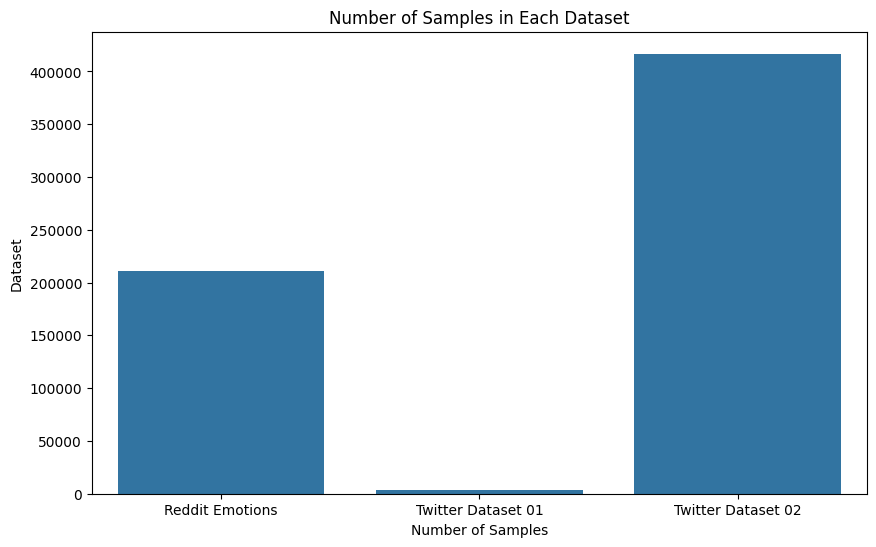

In [391]:
dataset_sizes = {
    "Reddit Emotions": len(reddit_emotion_dataset),
    "Twitter Dataset 01": len(twitter_dataset_01["train"]),
    "Twitter Dataset 02": len(twitter_dataset_02["train"])
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(dataset_sizes.keys()), y=list(dataset_sizes.values()))
plt.title('Number of Samples in Each Dataset')
plt.xlabel('Number of Samples')
plt.ylabel('Dataset')
plt.show()

# Datasets Preprocessing

## Reddit Dataset Preprocessing

To focus on the attributes relevant to our emotion analysis, we simplify the Reddit dataset by removing several columns.

While some features such as "author" or "subreddit" may provide valuable information to the emotion analysis, for now the task is simplified, as these columns are more likely to introduce noisiness into data.

In [392]:
reddit_emotion_dataset = reddit_emotion_dataset.remove_columns(["link_id",
                                                                "author",
                                                                "id",
                                                                "parent_id",
                                                                "created_utc",
                                                                "subreddit",
                                                                "example_very_unclear",
                                                                "rater_id"
                                                                ])

To ensure clarity, let's focus only on entries with **distinctly labeled emotions**. This involves two key filtering steps:
- Removing entries **without any emotion** (where all emotions labeled as 0).
- Selecting entries that are labeled with **exactly one emotion**.


In [393]:
reddit_emotion_features = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

def filter_zero_emotions(entry):
    return any(entry[emotion] > 0 for emotion in reddit_emotion_features)

def filter_single_emotion(entry):
    return sum(entry[emotion] for emotion in reddit_emotion_features) == 1

print("Original number of rows:", len(reddit_emotion_dataset))

reddit_emotion_dataset = reddit_emotion_dataset.filter(filter_zero_emotions)
reddit_emotion_dataset = reddit_emotion_dataset.filter(filter_single_emotion)

print("Filtered number of rows:", len(reddit_emotion_dataset))


Original number of rows: 211225
Filtered number of rows: 171820


In [394]:
reddit_emotion_dataset = reddit_emotion_dataset.to_pandas()

As can be seen from the data visualization, there is a strong prevalence of "**neutral**" emotion in the data.

While imbalanced data may pose a challange, no action required until other two datasets are not observed, as they might balance the data.

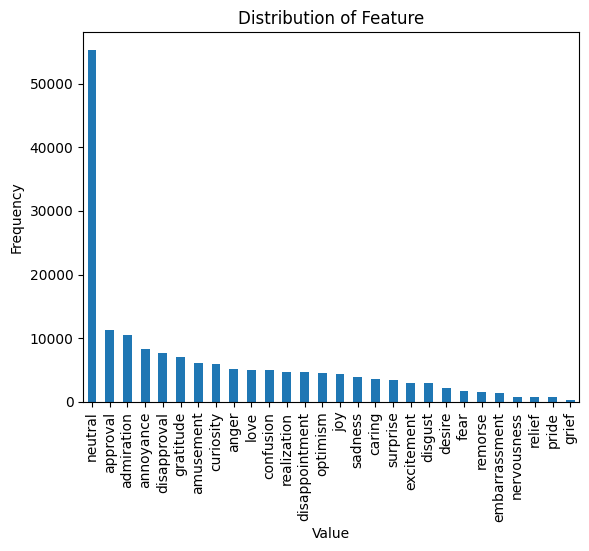

In [395]:
emotions_count = {}

for column in reddit_emotion_dataset.columns:
    if column != 'text':
        emotions_count[column] = (reddit_emotion_dataset[column] == 1).sum()

emotions_count = pd.Series(emotions_count)
emotions_count.sort_values(ascending=False, inplace=True)

emotions_count.plot(kind='bar')
plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [396]:
reddit_emotion_dataset["label"] = pd.from_dummies(reddit_emotion_dataset[reddit_emotion_features])
reddit_emotion_dataset = reddit_emotion_dataset[["text", "label"]]

## Twitter Dataset Preprocessing

In [397]:
twitter_dataset_01 = concatenate_datasets([twitter_dataset_01["train"], twitter_dataset_01["validation"], twitter_dataset_01["test"]])
twitter_dataset_01

Dataset({
    features: ['text', 'label'],
    num_rows: 5052
})

Let's adjust categorical labels to be more descriptive in order to ease the dataset concatenation with the rest of the data and future visualization tasks.

In [398]:
twitter_df_01 = twitter_dataset_01.to_pandas()
twitter_df_01['label'] = twitter_df_01['label'].astype('category')
twitter_df_01['label'] = twitter_df_01['label'].cat.rename_categories({0: "anger", 1: "joy", 2: "optimism", 3: "sadness"})
twitter_df_01


,text,label
0,“Worry is a down payment on a problem you may ...,optimism
1,My roommate: it's okay that we can't spell bec...,anger
2,No but that's so cute. Atsu was probably shy a...,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,anger
4,it's pretty depressing when u hit pan on ur fa...,sadness
...,...,...
5047,I need a sparkling bodysuit . No occasion. Jus...,joy
5048,@user I've finished reading it; simply mind-bl...,sadness
5049,shaft abrasions from panties merely shifted to...,anger
5050,All this fake outrage. Y'all need to stop 🤣,anger


As can be seen from the barchart below, the data is not balanced, with a clear prevalence of "anger". However, the number of entries is much smaller than that of other datasets, and therefore it can be assumed that this will not unbalance the data.

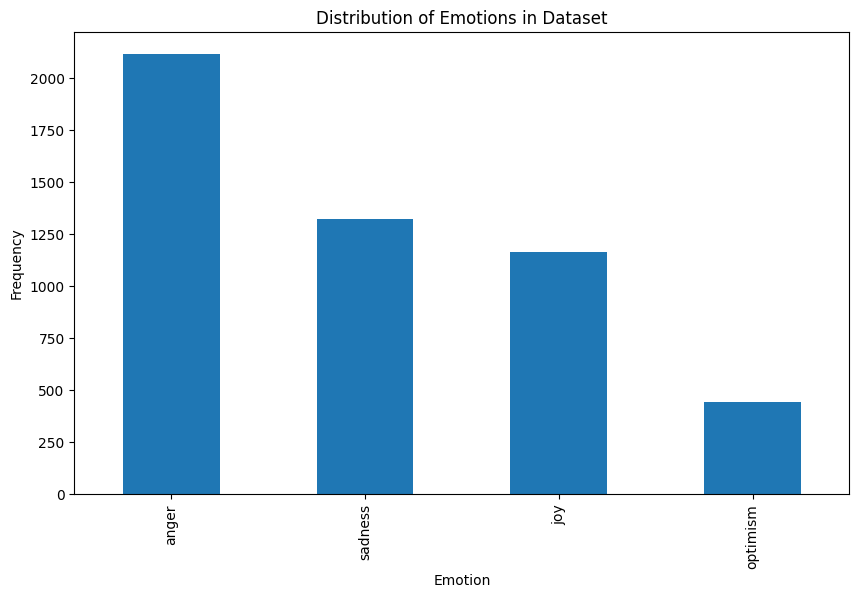

In [399]:
emotions_count = twitter_df_01['label'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
emotions_count.plot(kind='bar')
plt.title('Distribution of Emotions in Dataset')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

## Second Twitter Dataset Preprocessing

As in the example above, let us adjust categorical labels to be more descriptive.

In [400]:
twitter_df_02 = twitter_dataset_02["train"].to_pandas()
twitter_df_02['label'] = twitter_df_02['label'].astype('category')
twitter_df_02['label'] = twitter_df_02['label'].cat.rename_categories({0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"})

twitter_df_02

,text,label
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love
...,...,...
416804,that was what i felt when i was finally accept...,joy
416805,i take every day as it comes i m just focussin...,fear
416806,i just suddenly feel that everything was fake,sadness
416807,im feeling more eager than ever to claw back w...,joy


This dataset does not include a 'neutral' emotion and has a large number of entries, making it a valuable complement to the Reddit dataset.

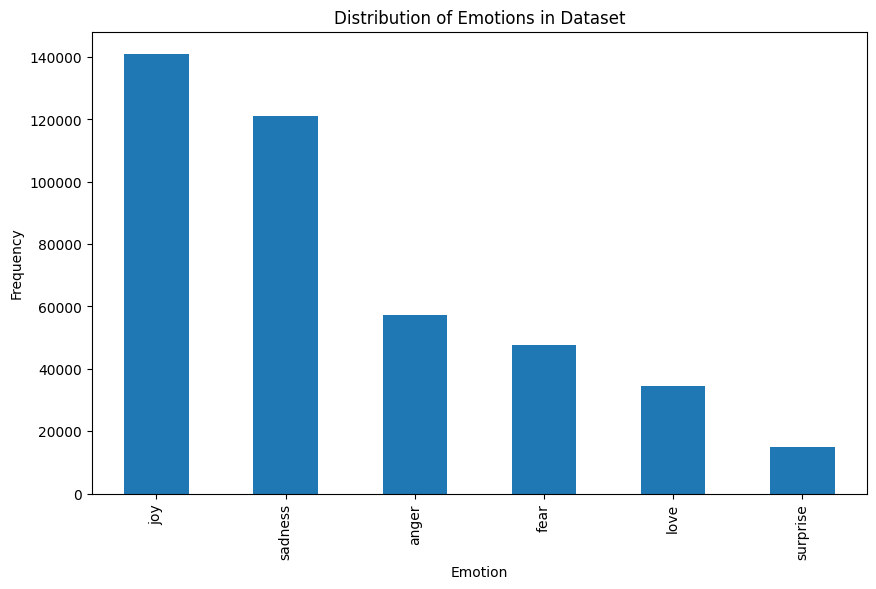

In [401]:
emotions_count = twitter_df_02['label'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
emotions_count.plot(kind='bar')
plt.title('Distribution of Emotions in Dataset')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

# Dataset Preparation for NLP

Firstly, let's combine all 3 datasets together.

In [402]:
emotion_df = pd.concat([twitter_df_01, twitter_df_02, reddit_emotion_dataset])
emotion_df

,text,label
0,“Worry is a down payment on a problem you may ...,optimism
1,My roommate: it's okay that we can't spell bec...,anger
2,No but that's so cute. Atsu was probably shy a...,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,anger
4,it's pretty depressing when u hit pan on ur fa...,sadness
...,...,...
171815,"Well, I'm glad you're out of all that now. How...",joy
171816,Everyone likes [NAME].,love
171817,Well when you’ve imported about a gazillion of...,caring
171818,That looks amazing,admiration


## Visualizing and Balancing the Data

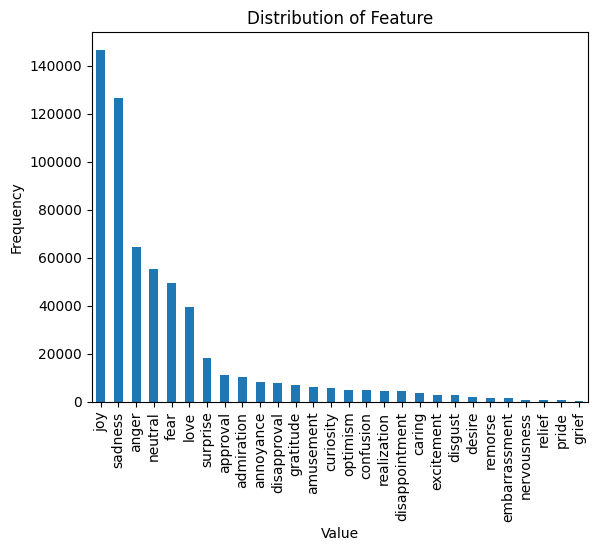

In [403]:
emotions_count = emotion_df['label'].value_counts()

emotions_count.plot(kind='bar')
plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

The plot above highlights a strong prevalence of basic emotions such as 'joy', 'sadness', 'anger', 'fear', 'love', 'surprise', and 'neutral'.

Given our goal of providing a single, distinct emotion as the model output, we'll simplify our dataset to include only these core emotions. This approach should enhance the model's accuracy.



In [404]:
emotion_df = emotion_df[emotion_df.label.isin(["text", "joy", "sadness", "anger", "neutral", "fear", "love", "surprise"])]
emotion_df = shuffle(emotion_df).reset_index(drop=True)
emotion_df

,text,label
0,i feel troubled by a lot of stuffs lately,sadness
1,i feel that we are all once again invigorated ...,joy
2,Only married once so can't be that bad. Not th...,neutral
3,i feel like i m heartbroken,sadness
4,i feel like a greedy little traitor i m lookin...,anger
...,...,...
500274,i was feeling a lot more gloomy than usual,sadness
500275,I'm sorry. I hope he takes the CTJ talk seriou...,surprise
500276,i feel like im abused emotionally,sadness
500277,i feel a bit gloomy this time of year as i wai...,sadness


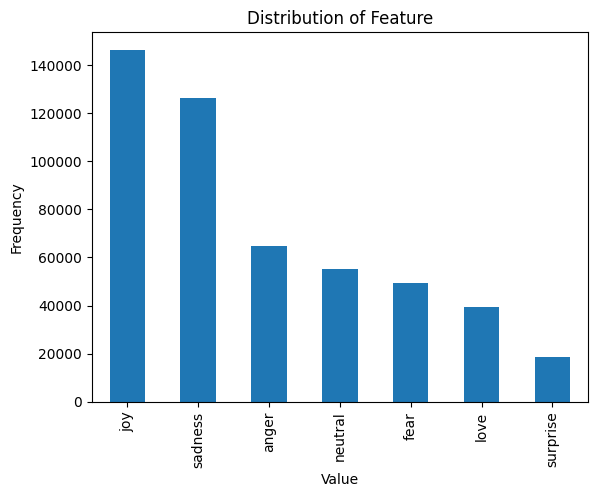

In [405]:
emotions_count = emotion_df['label'].value_counts()

emotions_count.plot(kind='bar')
plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Undersampling

In order to achieve a balanced dataset, it is first necessary to employ an undersampling technique. As the data frame has already been shuffled in the previous step, let's simply retain the first 50k samples.

The 50,000 sample size has been chosen as it is both sufficient for the model to be trained on and minimises the need for oversampling techniques in next steps.

In [406]:
SAMPLES_PER_CLASS = 50000
emotion_df = emotion_df.groupby('label').apply(lambda x: x.sample(SAMPLES_PER_CLASS) if len(x) > SAMPLES_PER_CLASS else x)
emotion_df = emotion_df.sample(frac=1).reset_index(drop=True)
emotion_df = emotion_df.dropna()

### Oversampling

In [407]:
all_surprise = emotion_df.loc[emotion_df['label'] == "surprise"]
all_surprise.reset_index(inplace=True, drop=True)

for i in range(6):
  random_sample = all_surprise.sample(3500)
  emotion_df = pd.concat([emotion_df, random_sample])

all_love = emotion_df.loc[emotion_df['label'] == "love"]
all_love.reset_index(inplace=True, drop=True)

random_sample = all_love.sample(3500)
emotion_df = pd.concat([emotion_df, random_sample])

In [408]:
emotion_df.reset_index(inplace=True, drop=True)

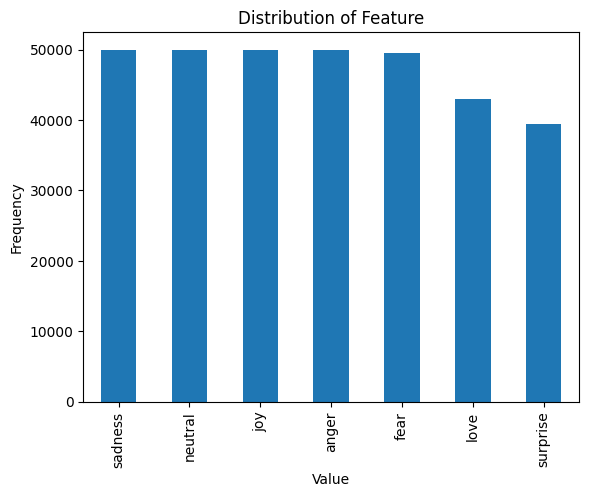

In [409]:
emotions_count = emotion_df['label'].value_counts()

emotions_count.plot(kind='bar')
plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Preprocess Text

Firstly, it is important to lowercase the data.

In [410]:
emotion_df['text']=emotion_df['text'].str.lower()

In [411]:
def expand_contractions(data):
  return contractions.fix(data)

def preprocess_spaces(data):
    return re.sub(' t ', '\'t ', data)

emotion_df['text']= emotion_df['text'].apply(lambda x: preprocess_spaces(x))
emotion_df['text']= emotion_df['text'].apply(lambda x: expand_contractions(x))

In [412]:
retain_words = {'not', 'no', 'nor', "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't",
                "hasn't", "haven't", "isn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't",
                "weren't", "won't", "wouldn't", "but", "didn", "mightn't", "against", "wouldn", "weren", "aren",
                "ain", "won", "t", "s", "needn", "couldn", "d", "doesn", "don",  'should', "should've",'shouldn', "over"}

stopwords_set = set(stopwords.words('english')) - retain_words

In [413]:
def cleaning_email(data):
    return re.sub('@[^\s]+', '', data)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

def cleaning_apostrophs(data):
    return re.sub('\'', '', data)

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', data)

emotion_df['text']=emotion_df['text'].apply(lambda x: cleaning_email(x))
emotion_df['text']=emotion_df['text'].apply(lambda x: cleaning_numbers(x))
emotion_df['text']=emotion_df['text'].apply(lambda x: cleaning_URLs(x))
emotion_df['text']=emotion_df['text'].apply(lambda x: cleaning_apostrophs(x))

emotion_df['text'] = emotion_df['text'].str.replace(r'\s+', ' ', regex=True)


In [414]:
def remove_stopwords(data):
  data = re.split(r"(\s+)", data)
  output_data = ""
  for word in data:
    if word in stopwords_set:
      output_data = output_data
    else:
      output_data += word

  return output_data.strip()

In [415]:
def cleaning_punct(data):
    punct_to_remove = string.punctuation.replace('!', '').replace('?', '')
    pattern = f"[{re.escape(punct_to_remove)}]"
    return re.sub(pattern, '', data)

emotion_df['text']= emotion_df['text'].apply(lambda x: cleaning_punct(x))

https://towardsdatascience.com/increasing-accuracy-of-sentiment-classification-using-negation-handling-9ed6dca91f53

In [416]:
non_negatable_pos = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'}


def negate_sentence(sentence):
    words = nltk.word_tokenize(sentence)

    temp = 0
    i = 1  # start from 1 to safely check the previous word for negations

    # Process each word in the sentence
    while i < len(words):
        word = words[i-1]
        word_pos = nltk.pos_tag(word_tokenize(word))[0][1]

        if (word in ['not']) and (word_pos not in non_negatable_pos):
            antonyms = []
            synsets = wordnet.synsets(words[i])
            if synsets:
                w1 = synsets[0].name()
                # Find antonyms for each lemma
                for syn in synsets:
                    for l in syn.lemmas():
                        if l.antonyms():
                            antonyms.append(l.antonyms()[0].name())

                # If antonyms were found, choose the best one based on similarity
                if antonyms:
                    max_dissimilarity = 0
                    for ant in antonyms:
                        syns = wordnet.synsets(ant)
                        if syns:
                            w2 = syns[0].name()
                            word1 = wordnet.synset(w1)
                            word2 = wordnet.synset(w2)
                            similarity = word1.wup_similarity(word2)
                            if similarity:
                                temp = 1 - similarity
                                if temp > max_dissimilarity:
                                    max_dissimilarity = temp
                                    antonym_max = ant
                                    words[i] = antonym_max  # Replace with the best antonym
                                    words[i-1] = ''  # Remove the negation word

        i += 1

    words = [word for word in words if word]

    sentence = ' '.join(words)
    sentence = re.sub(r' \?', '?', sentence)
    sentence = re.sub(r' !', '!', sentence)
    sentence = re.sub(r' \' ', '\'', sentence)
    return sentence

In [417]:
test_negation = emotion_df["text"][random.randint(0, 1000)]
print(test_negation)
print(negate_sentence(test_negation))

i just do them when i m feeling paranoid
i just do them when i m feeling paranoid


In [418]:
# emotion_df['text']= emotion_df['text'].apply(lambda x: negate_sentence(x))

Separate features and target

In [419]:
X = emotion_df['text']
y = emotion_df.drop('text', axis=1)

emotion_df['text'] = X
emotion_df['label'] = y

In [420]:
y = pd.get_dummies(y, columns=['label'])
y = y.astype(int)

In [421]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)


## Tokenization

In [422]:
def split_exc(data):
  print(data)
  splitted = tf.strings.split(data, sep="!")
  return splitted

In [423]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens = 20000,
                                                    output_sequence_length = 200)
vectorize_layer.adapt(X)

In [424]:
X_train = vectorize_layer(X_train)
X_test = vectorize_layer(X_test)

# Model Development

In [425]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=3,
                                        restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)

In [426]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(
      input_dim=20000,
      output_dim=100,
      mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.3)),

  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.4),

  tf.keras.layers.Dense(7, activation='softmax')
])

In [427]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [428]:
history = model.fit(X_train, y_train, batch_size=80, epochs=8, validation_split=0.25, verbose=1, callbacks=[early_stopping_callback, reduce_lr])

Epoch 1/8
2179/2179 [==============================] - 76s 31ms/step - loss: 0.5242 - accuracy: 0.8296 - precision_6: 0.8824 - recall_6: 0.7828 - val_loss: 0.2994 - val_accuracy: 0.8939 - val_precision_6: 0.9088 - val_recall_6: 0.8794 - lr: 0.0010
Epoch 2/8
2179/2179 [==============================] - 48s 22ms/step - loss: 0.2778 - accuracy: 0.9033 - precision_6: 0.9177 - recall_6: 0.8881 - val_loss: 0.2749 - val_accuracy: 0.9025 - val_precision_6: 0.9123 - val_recall_6: 0.8938 - lr: 0.0010
Epoch 3/8
2179/2179 [==============================] - 48s 22ms/step - loss: 0.2346 - accuracy: 0.9134 - precision_6: 0.9258 - recall_6: 0.9006 - val_loss: 0.2667 - val_accuracy: 0.9051 - val_precision_6: 0.9149 - val_recall_6: 0.8951 - lr: 0.0010
Epoch 4/8
2179/2179 [==============================] - 46s 21ms/step - loss: 0.2100 - accuracy: 0.9194 - precision_6: 0.9301 - recall_6: 0.9089 - val_loss: 0.2799 - val_accuracy: 0.9048 - val_precision_6: 0.9126 - val_recall_6: 0.8972 - lr: 0.0010
Epoch 5/

In [429]:
accr1 = model.evaluate(X_test[:100000], y_test[:100000]) #we are starting to test the model here


3112/3112 [==============================] - 21s 7ms/step - loss: 0.2652 - accuracy: 0.9054 - precision_6: 0.9155 - recall_6: 0.8953


<Axes: >

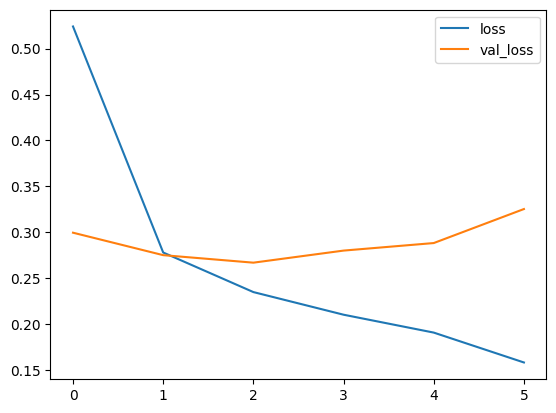

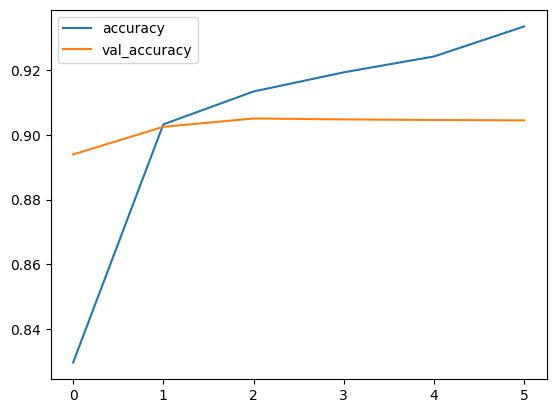

In [430]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [431]:
model.save("my_model.keras")

In [432]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_6 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_6 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 64)                0         
                                                                 
 dropout_6 (Dropout)         (None, 64)               

In [433]:
text = "idk wow???"
sequences = vectorize_layer(text)
sequences = tf.expand_dims(sequences, axis=0)  # Add batch dimension
sequences

<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[  1, 521,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   

In [434]:
prediction = model.predict(sequences)
predicted_index = np.argmax(prediction)

predicted_label = y.columns[predicted_index]
print(predicted_label)

1/1 [==============================] - 2s 2s/step
label_surprise


In [435]:
predictions = model.predict(X_test[:5000])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test[:5000], axis=1)

cm = confusion_matrix(true_classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

157/157 [==============================] - 1s 5ms/step
[[0.86675462 0.04221636 0.         0.         0.08311346 0.00527704
  0.00263852]
 [0.00658762 0.87878788 0.00131752 0.00131752 0.01976285 0.00131752
  0.09090909]
 [0.00537634 0.00672043 0.88575269 0.06048387 0.02688172 0.00134409
  0.01344086]
 [0.         0.         0.         0.9787234  0.0212766  0.
  0.        ]
 [0.0237467  0.00659631 0.00527704 0.01319261 0.92084433 0.00527704
  0.02506596]
 [0.03238866 0.02564103 0.00269906 0.         0.02294197 0.91497976
  0.00134953]
 [0.00687285 0.00343643 0.00171821 0.00171821 0.08419244 0.
  0.90206186]]


<Figure size 1500x1500 with 0 Axes>

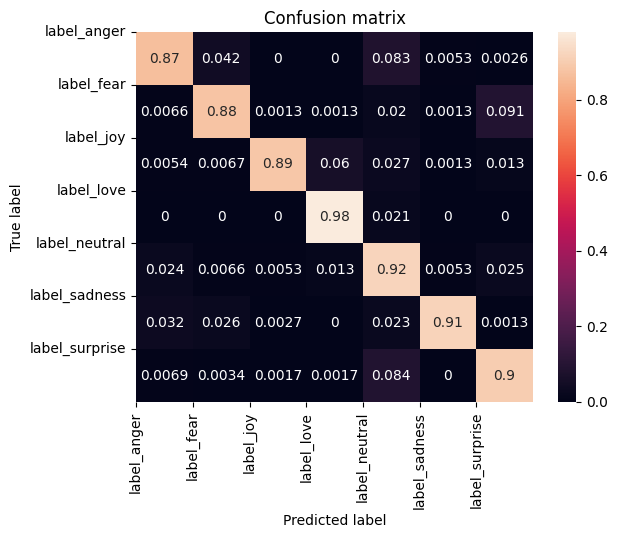

<Figure size 1500x1500 with 0 Axes>

In [436]:
classes = y.columns

sns.heatmap(cm, annot=True)
plt.title('Confusion matrix')

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes, rotation=0)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.figure(figsize=(15, 15))